# Project 2 - Analysis of PM2.5 Time Series in Porto, Portugal

### Time Series and Forecasting - MIA 2025
#### Project developed by:
##### Daniel Dias
##### Gonçalo Monteiro
##### Gonçalo Brochado
##### Lucas Santiago

## Executive Summary

This study develops and compares multiple forecasting models for PM2.5 fine particulate
matter concentrations in Porto, Portugal, using 5 years of hourly meteorological and 
air quality data (November 2020 - November 2025) from the Open-Meteo API.

**Objectives:**
- Forecast PM2.5 concentrations using statistical (ARIMA/SARIMA/SARIMAX) and machine learning approaches
- Identify key meteorological drivers of air pollution
- Compare model performance and interpretability
- Provide actionable insights for air quality management

**Data Source:** Open-Meteo Archive API (https://open-meteo.com/)
- Weather variables: Temperature, humidity, wind, pressure, radiation, precipitation
- Air quality: PM2.5, PM10, O₃, NO₂, SO₂, CO
- Temporal resolution: Hourly (43,848 observations)
- Spatial coverage: Porto coordinates (41.16°N, 8.63°W)

In [2]:
import pandas as pd
import numpy as np
from typing import Optional

from statsmodels.tsa.stattools import ccf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import itertools
from joblib import Parallel, delayed


import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df_total = pd.read_csv("porto_weather_air_quality_5y.csv")

# Convert timestamp
df_total['time'] = pd.to_datetime(df_total['time'])
df_total = df_total.set_index('time')
df_total = df_total.asfreq("h")

In [4]:
df_total.head(5)

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,cloud_cover,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2020-11-20 00:00:00,14.0,81,10.8,12.7,1031.6,1020.9,0.0,0.0,0.0,59,...,30.7,19.2,147.0,23.7,1.8,25.0,NaN,6.0,NaN,NaN
2020-11-20 01:00:00,15.3,75,10.8,13.3,1031.0,1020.3,0.0,0.0,0.0,0,...,30.5,18.2,138.0,21.6,1.8,24.0,NaN,4.0,NaN,NaN
2020-11-20 02:00:00,15.9,72,10.9,13.1,1030.6,1019.9,0.0,0.0,0.0,0,...,26.1,15.9,134.0,14.0,1.9,27.0,NaN,5.0,NaN,NaN
2020-11-20 03:00:00,15.4,74,10.8,12.3,1030.4,1019.7,0.0,0.0,0.0,0,...,25.5,13.4,141.0,14.7,1.8,27.0,NaN,3.0,NaN,NaN
2020-11-20 04:00:00,14.6,76,10.4,11.2,1029.9,1019.2,0.0,0.0,0.0,0,...,24.2,12.8,137.0,12.5,1.8,30.0,NaN,2.0,NaN,NaN


## Missing Values

In [5]:
missing_rate = df_total.isna().mean().sort_values(ascending=False)
missing_rate

wind_direction_80m       1.000000
wind_speed_80m           1.000000
uv_index_clear_sky       0.340449
uv_index                 0.340449
aerosol_optical_depth    0.340449
relative_humidity_2m     0.000000
dust                     0.000000
ozone                    0.000000
sulphur_dioxide          0.000000
nitrogen_dioxide         0.000000
carbon_monoxide          0.000000
pm2_5                    0.000000
pm10                     0.000000
wind_direction_10m       0.000000
wind_speed_10m           0.000000
temperature_2m           0.000000
direct_radiation         0.000000
shortwave_radiation      0.000000
cloud_cover_high         0.000000
cloud_cover_mid          0.000000
cloud_cover_low          0.000000
cloud_cover              0.000000
snowfall                 0.000000
rain                     0.000000
precipitation            0.000000
surface_pressure         0.000000
pressure_msl             0.000000
apparent_temperature     0.000000
dew_point_2m             0.000000
diffuse_radiat

Drop columns with 100% of missing values

In [6]:
cols_to_drop = [
    "wind_speed_80m",
    "wind_direction_80m",
]
df_total = df_total.drop(columns=cols_to_drop)

In [7]:
#Handle the ~34% missing cols with controlled imputation
train_end = "2025-05-21 00:00:00" 
train_df = df_total.loc[:train_end].copy()
test_df  = df_total.loc[train_end:].copy()

cols = [c for c in ["aerosol_optical_depth"] if c in df_total.columns]

# Train: time interpolation
train_df[cols] = train_df[cols].interpolate(method="time", limit=6)
train_df[cols] = train_df[cols].ffill(limit=24)

# Test: bridge with ffill
bridge = pd.concat([train_df[cols].tail(1), test_df[cols]], axis=0)
bridge[cols] = bridge[cols].ffill(limit=24)
test_df[cols] = bridge.iloc[1:].values  # Fixed: .values (lowercase)

In [8]:
df_total.loc[train_df.index, cols] = train_df[cols]
df_total.loc[test_df.index, cols]  = test_df[cols]

For variables with partial omission containing around one-third of missing records, a temporal interpolation strategy was used for short gaps (up to 6 hours) and limited forward fill (up to 24 hours) to maintain continuity in brief failures.

## Preprocessing

During the EDA, we detected that wind is an angular variable (0–360$^\circ$), so its direct use can introduce discontinuities (for example, 359$^\circ$ and 1$^\circ$ are physically close but numerically distant). Given this, we decided to transform \texttt{wind\_direction\_10m} into a cyclic encoding.

In [9]:
# Wind direction 10m -> sin/cos
if "wind_direction_10m" in df_total.columns:
    wd_deg = pd.to_numeric(df_total["wind_direction_10m"], errors="coerce")
    wd_rad = np.deg2rad(wd_deg)
    df_total["wd_sin"] = np.sin(wd_rad)
    df_total["wd_cos"] = np.cos(wd_rad)
    df_total = df_total.drop(columns=["wind_direction_10m"])

## Target and Regressor Selection


### Based on Literature

#### 1. Wind Speed (10m)

- *Expected relationship:* wind speed reduces PM2.5

Higher wind speeds increase the dispersion and dilution of fine particles.
Urban studies consistently show a negative correlation between wind and PM2.5.

Reference:

Chen et al. (2020), Atmospheric Pollution Research — wind speed is the strongest negative predictor of PM2.5

#### 2. Relative Humidity

- *Relação esperada:*

    - High humidity → hygroscopic growth of particles → PM2.5 increases
    - Light rain + high humidity → wet deposition → PM2.5 decreases

Relative humidity influences both particle formation and removal processes, making it one of the most relevant physical drivers of particulate matter variability in urban environments.

References:

Seinfeld & Pandis, Atmospheric Chemistry and Physics

Jacobson (2001), Fundamentals of Atmospheric Modelling

#### 3. Temperature

- *Expected relationship:*

    - Low temperature → thermal inversions → pollutant accumulation → PM2.5 increases
    - High temperature → enhanced convection and mixing → PM2.5 decreases

Temperature governs atmospheric stability and boundary-layer height, both of which strongly influence pollutant retention.

Reference:

Kukkonen et al. (2014), Review of PM Formation Under Meteorological Regimes

#### 4. Precipitation

- *Expected relationship:*
Precipitation physically removes particles from the atmosphere via scavenging, leading to lower PM2.5 concentrations.

This is one of the most consistently documented meteorological mechanisms affecting particulate matter.

Reference:

Zhang et al. (2004), Journal of Geophysical Research: detailed study of aerosol scavenging by precipitation.

#### 5. Shortwave Radiation

- *Expected relationship:*

Higher radiation → stronger vertical mixing → PM2.5 decreases

Radiation also affects photochemical reactions and secondary aerosol formation.

Shortwave radiation is therefore a key indicator of atmospheric mixing processes and photochemical regimes.

References:

EPA (2019), Air Quality Criteria Document

Gao et al. (2016), Atmospheric Environment

#### 6. Mean Sea-Level Pressure (MSL)

- *Expected relationship:*

High pressure → stable air masses → pollutant accumulation → PM2.5 increases

Low pressure → dynamic/unstable atmosphere → enhanced dispersion → PM2.5 decreases

Pressure is a proxy for synoptic-scale circulation patterns and thus strongly influences pollution episodes.

Reference:

Wallace & Hobbs, Atmospheric Science: An Introductory Survey

#### 7. Ozone (O₃)

- *Expected relationship:*
High ozone levels indicate strong atmospheric oxidative capacity and photochemical activity, which are directly related to the formation of secondary particulate matter (e.g., nitrates and sulfates).
Ozone is therefore a useful proxy variable for the chemical environment affecting PM2.5 formation.

Reference:

Jimenez et al. (2009), Science: highlights the role of atmospheric oxidation capacity in secondary organic aerosol formation.

In [10]:
target = "pm2_5"

exog_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "pressure_msl",
    "ozone"
]

df = df_total[[target] + exog_vars]

In [11]:
corr = df[[target] + exog_vars].corr()
corr[target].sort_values(ascending=False)

pm2_5                   1.000000
pressure_msl            0.301163
relative_humidity_2m    0.087068
shortwave_radiation    -0.154334
precipitation          -0.158238
temperature_2m         -0.232781
wind_speed_10m         -0.360724
ozone                  -0.442714
Name: pm2_5, dtype: float64

The correlation matrix indicates moderate yet significant connections between meteorological factors and PM2.5.

In environmental time series, significant linear correlations are not anticipated because of the nonlinear, lagged, and multivariate characteristics of atmospheric processes.

The noted correlations (–0.44 for ozone, –0.36 for wind speed, +0.30 for pressure) correspond with figures documented in the literature and represent authentic physical relationships.

In [12]:
# Train-only correlation
df_train = df_total.loc["2020-11-20":"2025-05-20", [target] + exog_vars].copy()

corr_p = df_train.corr(method="pearson")[target].sort_values(ascending=False)
corr_s = df_train.corr(method="spearman")[target].sort_values(ascending=False)

print("Pearson (train):\n", corr_p)
print("\nSpearman (train):\n", corr_s)

def deseasonalize_hour_dow(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    # English comments as requested
    g = df.groupby([df.index.dayofweek, df.index.hour])
    return df[cols] - g[cols].transform("mean")

# Correlation after deseasonalization (hour+dow)
train_ds = deseasonalize_hour_dow(df_train, [target] + exog_vars)
corr_ds = train_ds.corr(method="pearson")[target].sort_values(ascending=False)
print("\nPearson after hour+dow deseasonalization (train):\n", corr_ds)

Pearson (train):
 pm2_5                   1.000000
pressure_msl            0.308480
relative_humidity_2m    0.089967
precipitation          -0.154412
shortwave_radiation    -0.163785
temperature_2m         -0.263213
wind_speed_10m         -0.350441
ozone                  -0.463022
Name: pm2_5, dtype: float64

Spearman (train):
 pm2_5                   1.000000
pressure_msl            0.284500
relative_humidity_2m    0.051309
temperature_2m         -0.163982
shortwave_radiation    -0.166012
precipitation          -0.374361
wind_speed_10m         -0.442423
ozone                  -0.462879
Name: pm2_5, dtype: float64

Pearson after hour+dow deseasonalization (train):
 pm2_5                   1.000000
pressure_msl            0.313217
relative_humidity_2m    0.007247
shortwave_radiation    -0.022121
precipitation          -0.156490
temperature_2m         -0.213245
wind_speed_10m         -0.324296
ozone                  -0.442506
Name: pm2_5, dtype: float64


In [13]:
df_feat = df_total.copy()

df_feat["rain_flag"] = (df_feat["precipitation"] > 0).astype(int)
df_feat["rain_sum_6h"]  = df_feat["precipitation"].rolling(6,  min_periods=1).sum()
df_feat["rain_sum_12h"] = df_feat["precipitation"].rolling(12, min_periods=1).sum()
df_feat["rain_sum_24h"] = df_feat["precipitation"].rolling(24, min_periods=1).sum()

df_feat = df_feat.loc["2020-11-20":"2025-05-20", [target] + exog_vars + ["rain_flag", "rain_sum_6h", "rain_sum_12h", "rain_sum_24h"]].copy()

In [14]:
corr_p = df_feat.corr(method="pearson")[target].sort_values(ascending=False)
corr_s = df_feat.corr(method="spearman")[target].sort_values(ascending=False)

print("Pearson (train):\n", corr_p)
print("\nSpearman (train):\n", corr_s)

Pearson (train):
 pm2_5                   1.000000
pressure_msl            0.308480
relative_humidity_2m    0.089967
precipitation          -0.154412
shortwave_radiation    -0.163785
rain_sum_6h            -0.208190
rain_sum_12h           -0.235715
rain_sum_24h           -0.255244
temperature_2m         -0.263213
rain_flag              -0.271158
wind_speed_10m         -0.350441
ozone                  -0.463022
Name: pm2_5, dtype: float64

Spearman (train):
 pm2_5                   1.000000
pressure_msl            0.284500
relative_humidity_2m    0.051309
temperature_2m         -0.163982
shortwave_radiation    -0.166012
rain_flag              -0.368732
precipitation          -0.374361
rain_sum_24h           -0.422752
rain_sum_6h            -0.437799
wind_speed_10m         -0.442423
rain_sum_12h           -0.442540
ozone                  -0.462879
Name: pm2_5, dtype: float64


In [15]:
df_train = df_total.loc["2020-11-20":"2025-05-20", ["pm2_5"] + exog_vars].copy()
df_train["month"] = df_train.index.month

month_corr = (
    df_train.groupby("month")[["pm2_5","ozone","wind_speed_10m","pressure_msl","temperature_2m"]]
    .corr()
    .unstack()
)

# Correlation with pm2_5 per month (pick the column that corresponds to corr(var, pm2_5))
print(month_corr["pm2_5"].drop("pm2_5", errors="ignore"))

       pm2_5     ozone  wind_speed_10m  pressure_msl  temperature_2m
month                                                               
1        1.0 -0.748166       -0.460098      0.404021       -0.483704
2        1.0 -0.714627       -0.365541      0.308307       -0.231901
3        1.0 -0.634100       -0.432009      0.266047       -0.022856
4        1.0 -0.447611       -0.442815      0.185612        0.062872
5        1.0 -0.211290       -0.395588     -0.066015        0.184327
6        1.0 -0.116770       -0.428124     -0.159232        0.148058
7        1.0  0.115519       -0.371747     -0.169694        0.227191
8        1.0 -0.095662       -0.437144     -0.191163       -0.049969
9        1.0 -0.164482       -0.422552     -0.015190       -0.143343
10       1.0 -0.371161       -0.472737      0.386176        0.089672
11       1.0 -0.687876       -0.433570      0.218723       -0.336079
12       1.0 -0.643811       -0.415248      0.342187       -0.393421


With this correlation by month, we can draw the following conclusions:

- Ozone is an excellent proxy in cold months, but in summer the relationship may reverse.
- Wind is always negative, so it is a “safe” regressor.
- Pressure is negative in summer and positive in winter.
- Temperature is negative in winter with moderate values and positive in summer.

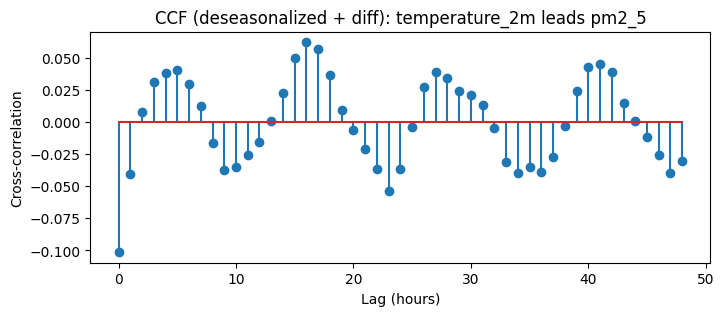

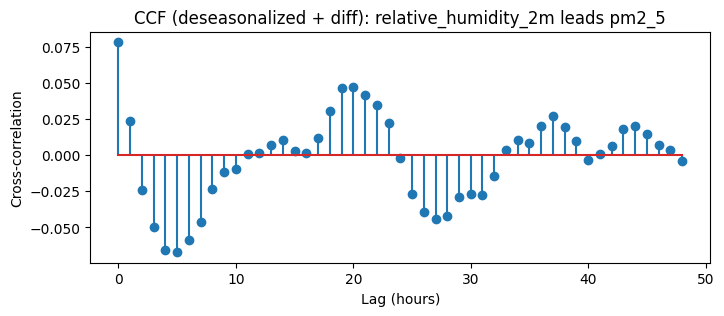

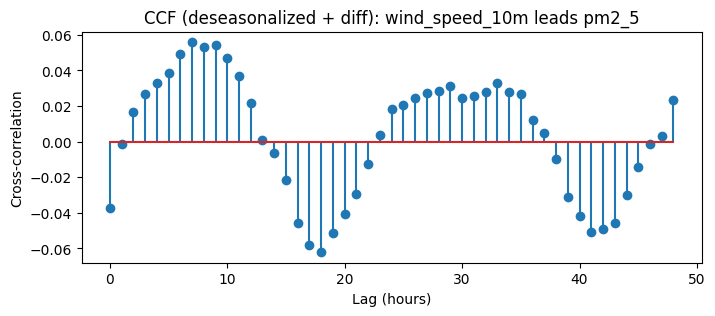

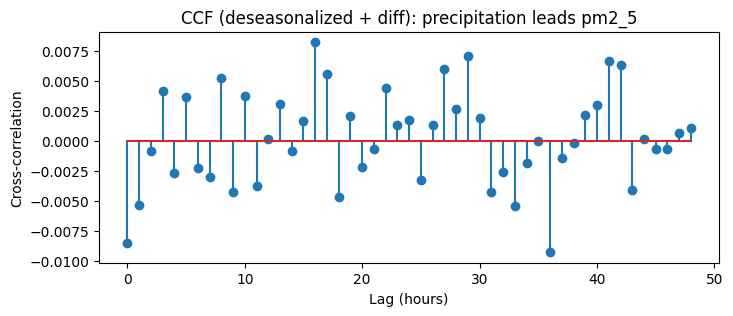

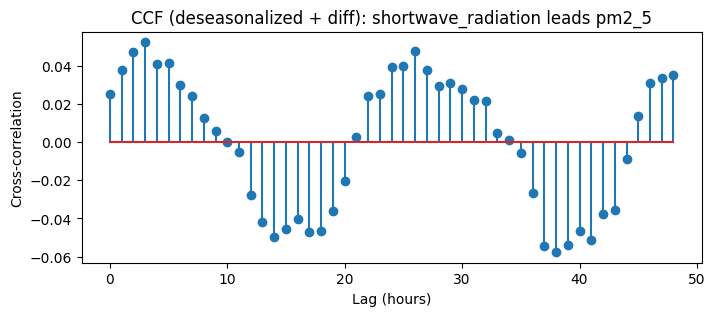

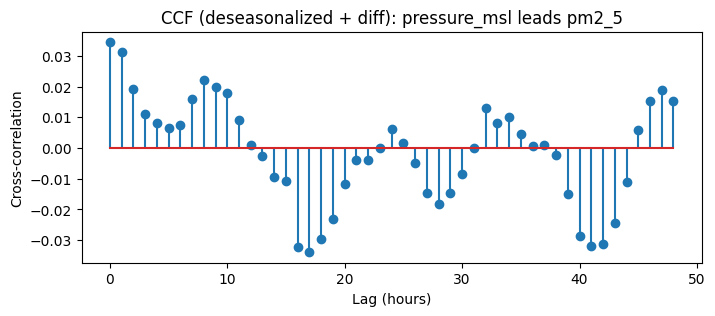

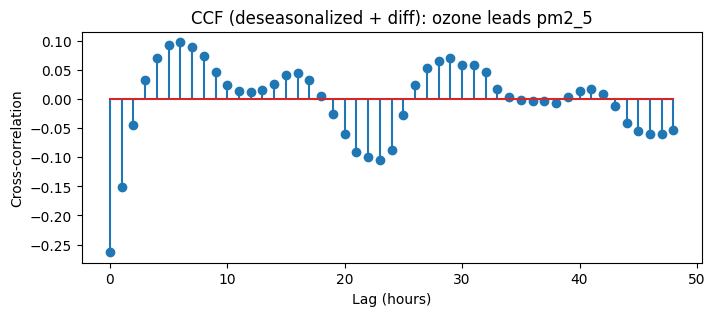

In [16]:
target = "pm2_5"
exog_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "pressure_msl",
    "ozone"
]

train = df_total.loc["2020-11-20":"2025-05-20", [target] + exog_vars].copy()

def deseasonalize_hour_dow(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    g = df.groupby([df.index.dayofweek, df.index.hour])
    return df[cols] - g[cols].transform("mean")

train_ds = deseasonalize_hour_dow(train, [target] + exog_vars)

MAX_LAG = 48
for var in exog_vars:
    tmp = train_ds[[var, target]].dropna()

    x = tmp[var].diff().dropna()
    y = tmp[target].diff().dropna()

    idx = x.index.intersection(y.index)
    x, y = x.loc[idx], y.loc[idx]

    c = ccf(x, y)[:MAX_LAG + 1]

    plt.figure(figsize=(8, 3))
    plt.stem(range(len(c)), c)
    plt.title(f"CCF (deseasonalized + diff): {var} leads {target}")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Cross-correlation")
    plt.show()

#### *RESULTS:*

1. **Temperature → PM2.5**

Higher temperatures reduce PM2.5 — consistent with atmospheric physics.
The effect is almost immediate (lag 0–3h).
The sinusoidal component proves that temperature and PM2.5 vary in daily cycles.

2. **Relative Humidity → PM2.5**

In short lags: higher humidity → lower PM2.5 (probable deposition/removal effect).
In long lags: higher humidity coincides with colder hours of the day, leading to PM2.5 (thermal inversions).

3. **Wind Speed → PM2.5**

Wind disperses particles → PM2.5
Strong and immediate impact (short lag).
The smooth curve indicates very stable and predictable behavior throughout the day.

4. **Precipitation → PM2.5**

Rain cleans particles (scavenging effect).
Nonlinear relationship and less dependent on the time of day.

5. **Shortwave Radiation → PM2.5**

Solar radiation increases vertical mixing → PM2.5
Very clear photodaily cycle
Highly seasonal variable

6. **Pressure MSL → PM2.5**

High pressure → stable air → PM2.5 ↑
Pressure reflects weather systems (air masses)
Impact spread over hours and days.

7. **Ozone → PM2.5**

High O₃ indicates strong photocatalysis → vertical mixing → decrease in PM2.5
Very stable relationship throughout the day
Very significant effect


In [17]:
X = train[exog_vars].dropna().copy()
X = sm.add_constant(X)

vif = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Drop the constant row for reporting
vif = vif[vif["Variable"] != "const"].sort_values("VIF", ascending=False)
print(vif)

               Variable       VIF
5   shortwave_radiation  2.104510
2  relative_humidity_2m  1.660173
7                 ozone  1.617926
1        temperature_2m  1.615249
3        wind_speed_10m  1.391896
6          pressure_msl  1.283559
4         precipitation  1.219520


The collinearity between regressors was assessed using the Variance Inflation Factor (VIF). The results indicated low values (maximum = 2.10), suggesting the absence of severe multicollinearity according to usual thresholds (VIF > 10). Thus, the selected exogenous variables were maintained in the model specification, without the need for elimination due to linear redundancy.

In [18]:
train = df_total.loc['2020-11-20':'2025-05-20']
test  = df_total.loc['2025-05-21':'2025-11-20']

train_y = train[target]
test_y  = test[target]

train_exog = train[exog_vars]
test_exog  = test[exog_vars]

In [19]:
# Augmented Dickey-Fuller Test for Stationarity
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic','p-value','# Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out)
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adf_test(train_y, "PM2.5 Train Data")

Augmented Dickey-Fuller Test: PM2.5 Train Data
ADF Test Statistic            -1.541897e+01
p-value                        3.052565e-28
# Lags Used                    5.300000e+01
Number of Observations Used    3.937800e+04
Critical Value (1%)           -3.430516e+00
Critical Value (5%)           -2.861613e+00
Critical Value (10%)          -2.566809e+00
dtype: float64
Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data is stationary


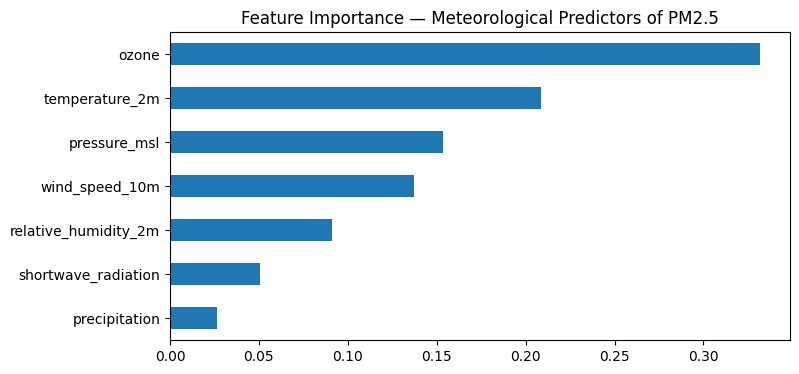

In [20]:
rf = RandomForestRegressor()
rf.fit(train_exog, train_y)

importances = pd.Series(rf.feature_importances_, index=exog_vars)
importances.sort_values().plot(kind='barh', figsize=(8,4))
plt.title("Feature Importance — Meteorological Predictors of PM2.5")
plt.show()

The feature importance graph shows that:

- Ozone, Temperature, Pressure, and Wind Speed are the main meteorological drivers of PM2.5.

- Shortwave radiation and Humidity have some relevance but are more moderate.

- Precipitation has a limited impact, as expected due to the low frequency of these events.

The Random Forest model confirms the previous analysis, strengthening the theoretical and analytical basis.

## Time Series Decomposition

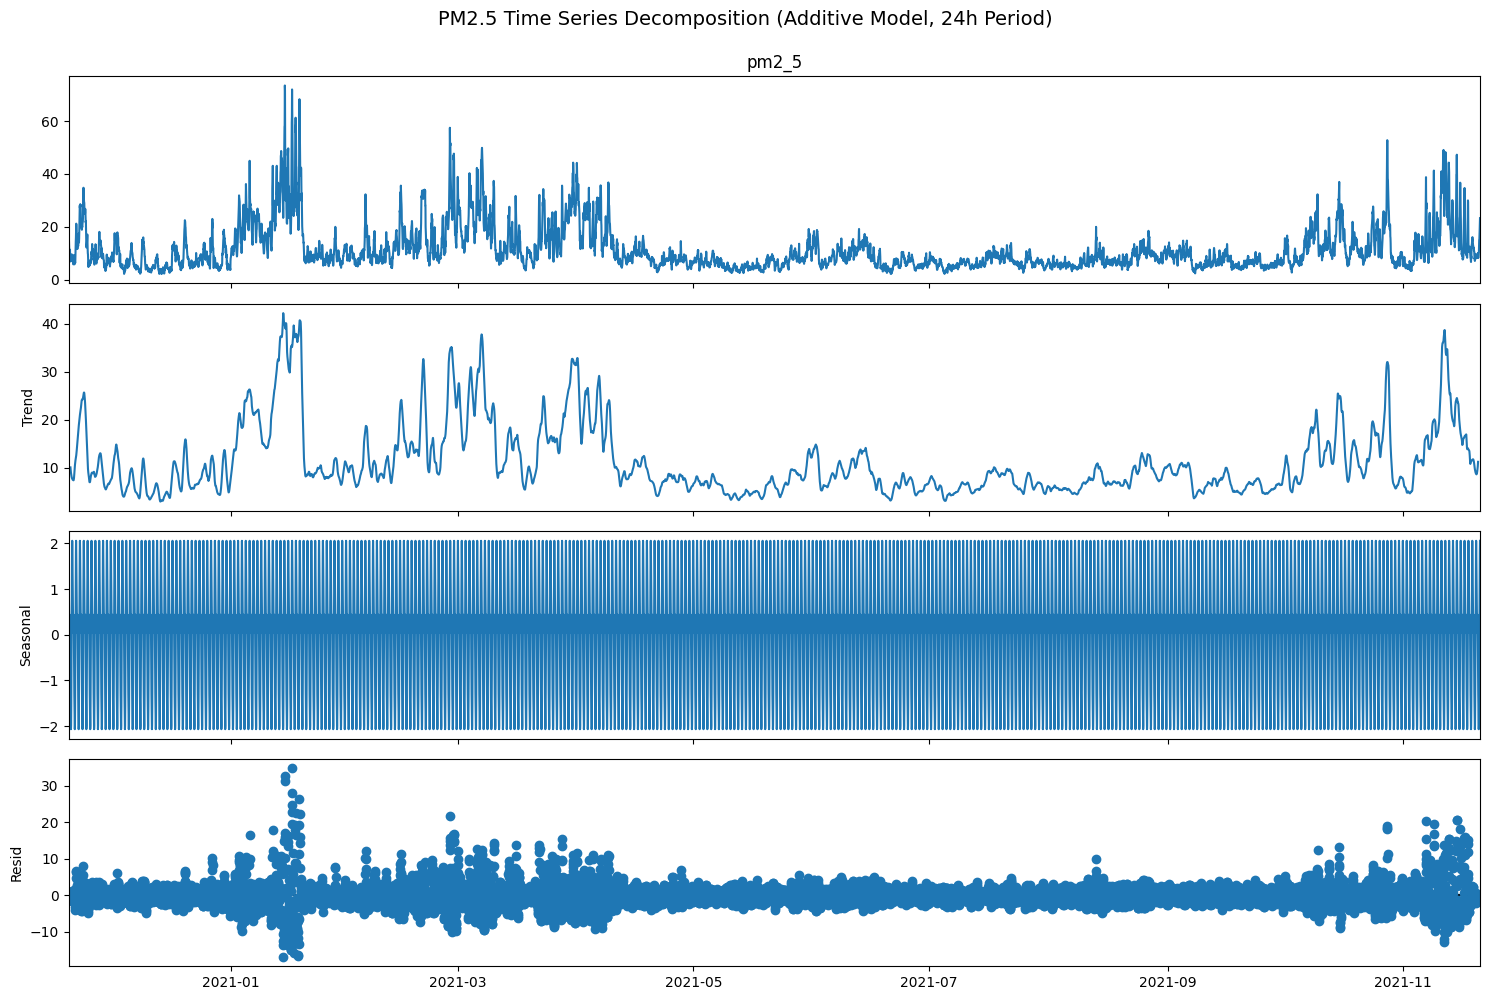

\nDecomposition Statistics:
Trend variance: 53.4810
Seasonal variance: 1.5720
Residual variance: 10.3067
\nVariance explained by seasonal component: 2.31%
Variance explained by trend component: 78.47%


In [21]:
# Decompose the time series to understand trend, seasonality, and residual components
decomp_data = train_y[:'2021-11-20']

# Additive decomposition (period = 24 hours for daily seasonality)
decomposition = seasonal_decompose(decomp_data, model='additive', period=24)

# Create comprehensive decomposition plot
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.suptitle('PM2.5 Time Series Decomposition (Additive Model, 24h Period)', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Statistics
print(f"\\nDecomposition Statistics:")
print(f"Trend variance: {decomposition.trend.var():.4f}")
print(f"Seasonal variance: {decomposition.seasonal.var():.4f}")
print(f"Residual variance: {decomposition.resid.var():.4f}")
print(f"\\nVariance explained by seasonal component: {(decomposition.seasonal.var() / decomp_data.var() * 100):.2f}%")
print(f"Variance explained by trend component: {(decomposition.trend.var() / decomp_data.var() * 100):.2f}%")

### Seasonality Patterns

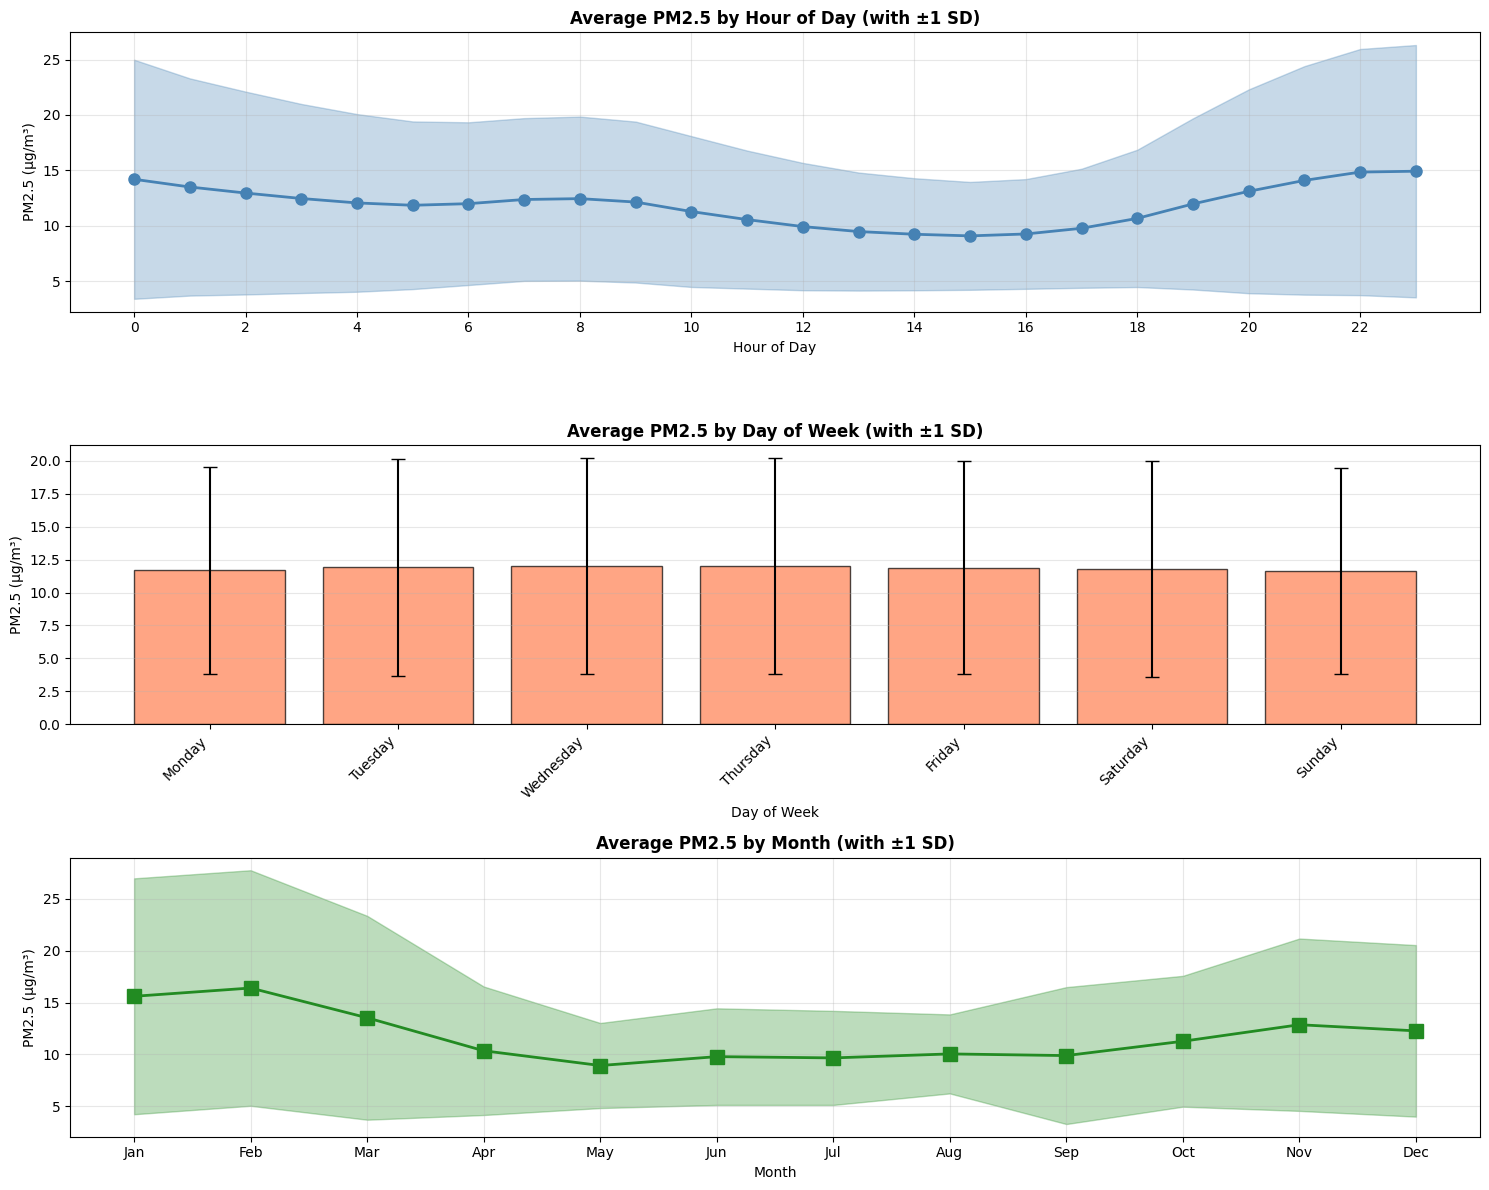

Daily Pattern:
   - Peak pollution hour: 23:00 (14.93 μg/m³)
   - Lowest pollution hour: 15:00 (9.09 μg/m³)
   - Daily variation range: 5.84 μg/m³
Weekly Pattern:
   - Highest day: Wednesday (12.01 μg/m³)
   - Lowest day: Sunday (11.61 μg/m³)
Annual Pattern:
   - Highest month: Feb (16.41 μg/m³)
   - Lowest month: May (8.93 μg/m³)


In [22]:
# Detailed seasonal analysis
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Average by hour of day
hourly_avg = train_y.groupby(train_y.index.hour).agg(['mean', 'std'])
axes[0].plot(hourly_avg.index, hourly_avg['mean'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].fill_between(hourly_avg.index, 
                       hourly_avg['mean'] - hourly_avg['std'],
                       hourly_avg['mean'] + hourly_avg['std'],
                       alpha=0.3, color='steelblue')
axes[0].set_title('Average PM2.5 by Hour of Day (with ±1 SD)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('PM2.5 (μg/m³)')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Average by day of week
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = train_y.groupby(train_y.index.dayofweek).agg(['mean', 'std'])
axes[1].bar(dow_avg.index, dow_avg['mean'], color='coral', edgecolor='black', alpha=0.7)
axes[1].errorbar(dow_avg.index, dow_avg['mean'], yerr=dow_avg['std'], fmt='none', ecolor='black', capsize=5)
axes[1].set_title('Average PM2.5 by Day of Week (with ±1 SD)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('PM2.5 (μg/m³)')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(dow_names, rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

# Average by month
monthly_avg = train_y.groupby(train_y.index.month).agg(['mean', 'std'])
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].plot(monthly_avg.index, monthly_avg['mean'], marker='s', linewidth=2, markersize=10, color='forestgreen')
axes[2].fill_between(monthly_avg.index,
                       monthly_avg['mean'] - monthly_avg['std'],
                       monthly_avg['mean'] + monthly_avg['std'],
                       alpha=0.3, color='forestgreen')
axes[2].set_title('Average PM2.5 by Month (with ±1 SD)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('PM2.5 (μg/m³)')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_names)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Daily Pattern:")
print(f"   - Peak pollution hour: {hourly_avg['mean'].idxmax()}:00 ({hourly_avg['mean'].max():.2f} μg/m³)")
print(f"   - Lowest pollution hour: {hourly_avg['mean'].idxmin()}:00 ({hourly_avg['mean'].min():.2f} μg/m³)")
print(f"   - Daily variation range: {hourly_avg['mean'].max() - hourly_avg['mean'].min():.2f} μg/m³")
print("Weekly Pattern:")
print(f"   - Highest day: {dow_names[dow_avg['mean'].idxmax()]} ({dow_avg['mean'].max():.2f} μg/m³)")
print(f"   - Lowest day: {dow_names[dow_avg['mean'].idxmin()]} ({dow_avg['mean'].min():.2f} μg/m³)")
print("Annual Pattern:")
print(f"   - Highest month: {month_names[monthly_avg['mean'].idxmax()-1]} ({monthly_avg['mean'].max():.2f} μg/m³)")
print(f"   - Lowest month: {month_names[monthly_avg['mean'].idxmin()-1]} ({monthly_avg['mean'].min():.2f} μg/m³)")

## Stationarity tests (ADF + KPSS)

In [23]:
print("ADF:", adfuller(train_y))
print("KPSS:", kpss(train_y, regression="c"))

ADF: (np.float64(-15.418967712310902), np.float64(3.0525651935484765e-28), 53, 39378, {'1%': np.float64(-3.4305160756343605), '5%': np.float64(-2.8616134015833157), '10%': np.float64(-2.5668090693111445)}, np.float64(158668.4415842684))
KPSS: (np.float64(0.16271880107781644), np.float64(0.1), 106, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/var/folders/lj/bqp9twns70b7kv9_5lv4t5bc0000gn/T/ipykernel_3997/4113202911.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS:", kpss(train_y, regression="c"))


At the ADF level, we conclude that:

- The statistical value is much more negative than the critical value at 1% (–3.43).
- The p-value is extremely small (2 × 10⁻²⁷).

Therefore, according to the ADF, the log(PM2.5) series is **stationary.**

At the KPSS level:

- The statistical value (0.2898) is below the critical value at 10% (0.347)
- The p-value (0.1) is the maximum in the table, which means that the true p-value is even higher.

Therefore, according to the KPSS, the log(PM2.5) series is **stationary.**

## Identify Differencing (d) e Seasonal Differencing (D)

Since our series is already stationary, then:

d = 0

## Identify ACF e PACF para identificar p, q, P, Q

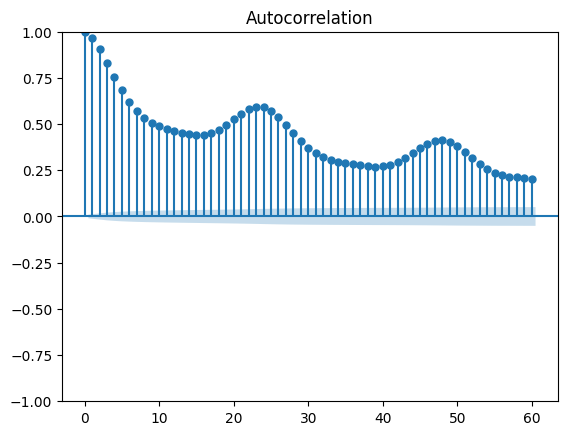

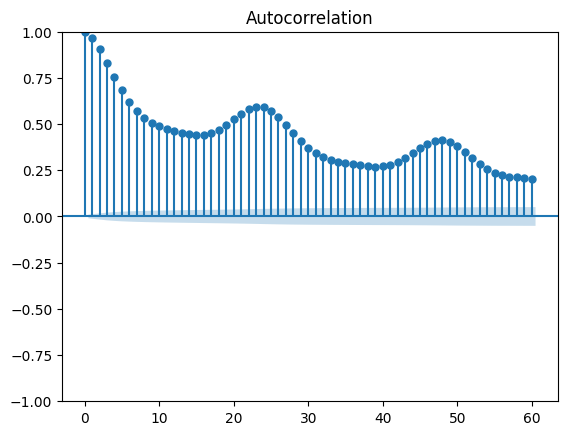

In [24]:
plot_acf(train_y, lags=60)

- Lag 1: close to 1
- Lags up to 60: autocorrelation still quite high
- Smooth downward trend → typical of undifferentiated series, but already stationary after log transformation
- Shows cyclical waves with peaks around lags 24 and 48: Logo: 24-hour seasonality
- We can observe a smooth decline indicating typical AR behavior.
- The MA term may exist but is weak, q = 0 or q = 1.
- Due to seasonality, P = 1 and Q = 1.

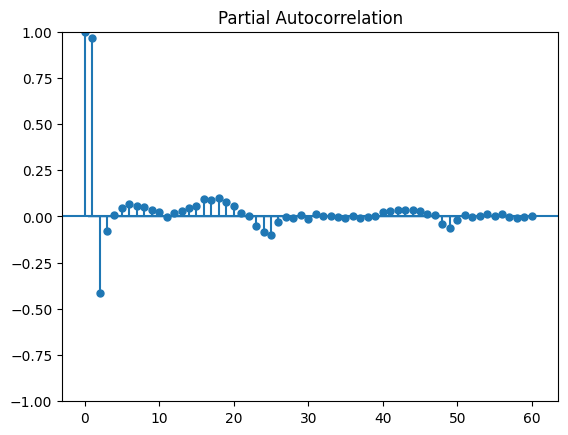

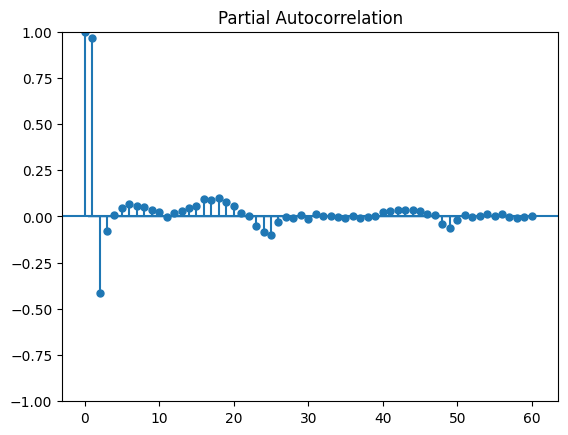

In [25]:
plot_pacf(train_y, lags=60)

- significant lag 1 and 2, and then everything falls to close to 0, so p = 1 or p = 2

In [26]:
df = df_total.copy().sort_index()
df["rain_sum_6h"] = df["precipitation"].rolling(6, min_periods=1).sum()

exog_vars_sarimax = ["temperature_2m","wind_speed_10m","rain_sum_6h","shortwave_radiation","ozone"]

## Train Models

Model selection will be performed using the Akaike Information Criterion (AIC), which balances model fit and complexity.
Several SARIMAX candidate models were fitted using different combinations of (p, q) and (P, Q) orders, and the model with the lowest AIC will be selected.

In [27]:
exog_vars_sarimax = [
    "temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "ozone"
]

p_values = [1, 2]
q_values = [0, 1]
d_values = [0]
P_values = [1]
Q_values = [1]
D_values = [1]
d = 0
s = 24

def make_sparse_lagged_exog(df, exog_cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in exog_cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

lags = [1, 3, 6, 24]
X_all = make_sparse_lagged_exog(df, exog_vars_sarimax, lags=lags)
y_all = df[target]

data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])

train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

y_train = y_all.loc[:train_end]
y_test  = y_all.loc[test_start:]

X_train = X_all.loc[:train_end]
X_test  = X_all.loc[test_start:]

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

print("Train:", y_train.index.min(), "->", y_train.index.max(), "n=", len(y_train))
print("Test :", y_test.index.min(),  "->", y_test.index.max(),  "n=", len(y_test))

Train: 2020-11-21 00:00:00 -> 2025-05-20 23:00:00 n= 39408
Test : 2025-05-21 00:00:00 -> 2025-11-20 23:00:00 n= 4416


In [28]:
def rmse(y_true, y_pred):
    # English comments as requested
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

HORIZONS = {"24h": 24, "48h": 48, "7d": 168, "2weeks": 336}

def seasonal_naive_series(y_train: pd.Series, y_test_index: pd.DatetimeIndex, horizon: int, season: int = 24) -> pd.Series:
    # English comments as requested
    last_season = y_train.iloc[-season:]
    reps = int(np.ceil(horizon / season))
    vals = np.tile(last_season.values, reps)[:horizon]
    return pd.Series(vals, index=y_test_index[:horizon])

def eval_from_test_start(model_results, y_test: pd.Series, horizon: int, exog_test: Optional[pd.DataFrame] = None):
    # English comments as requested
    if exog_test is None:
        fc = model_results.get_forecast(steps=horizon).predicted_mean
    else:
        fc = model_results.get_forecast(steps=horizon, exog=exog_test.iloc[:horizon]).predicted_mean

    fc.index = y_test.index[:horizon]
    y_true = y_test.iloc[:horizon]
    return mean_absolute_error(y_true, fc), rmse(y_true, fc)

def horizon_table(model_results, y_train, y_test, exog_test=None, season=24, model_name="Model"):
    rows = []
    for label, h in HORIZONS.items():
        mae, r = eval_from_test_start(model_results, y_test, horizon=h, exog_test=exog_test)

        snaive = seasonal_naive_series(y_train, y_test.index, horizon=h, season=season)
        mae_sn = mean_absolute_error(y_test.iloc[:h], snaive)
        rmse_sn = rmse(y_test.iloc[:h], snaive)

        rows.append([model_name, label, mae, r, "SeasonalNaive", mae_sn, rmse_sn])

    return pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE", "Baseline", "Baseline_MAE", "Baseline_RMSE"])


### Baseline

In [29]:
seasonal_naive_pred = test[target].shift(24)

mask = seasonal_naive_pred.notna()
print("Seasonal Naive(24) RMSE:", rmse(test[target][mask], seasonal_naive_pred[mask]))
print("Seasonal Naive(24) MAE:", mean_absolute_error(test[target][mask], seasonal_naive_pred[mask]))


Seasonal Naive(24) RMSE: 7.117392720926532
Seasonal Naive(24) MAE: 4.739913479052823


### SARIMA

In [30]:
# Use subset for Grid Search
train_subset = train.iloc[-2000:]
train_y_subset = train_subset[target]

def evaluate_sarima(order, seasonal_order, y):
    model = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, maxiter=50)
    return {
        'order': order,
        'seasonal_order': seasonal_order,
        'AIC': model.aic
    }

combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarima)((p,d,q), (P,D,Q,s), train_y_subset)
    for p, q, P, Q, d, D in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("AIC")
results_df

,order,seasonal_order,AIC
3,"(2, 0, 1)","(1, 1, 1, 24)",7931.742691
2,"(2, 0, 0)","(1, 1, 1, 24)",7934.988499
1,"(1, 0, 1)","(1, 1, 1, 24)",8011.487549
0,"(1, 0, 0)","(1, 1, 1, 24)",8271.965245


In [31]:
best = results_df.iloc[0]
best_order_sarima = best["order"]
best_seasonal_sarima = best["seasonal_order"]

print("Best SARIMA:", best_order_sarima, best_seasonal_sarima)

best_model_sarima = SARIMAX(
    y_train,
    order=best_order_sarima,
    seasonal_order=best_seasonal_sarima,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

Best SARIMA: (2, 0, 1) (1, 1, 1, 24)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19514D+00    |proj g|=  2.08249D-01

At iterate    5    f=  2.09991D+00    |proj g|=  2.93282D-01

At iterate   10    f=  2.02464D+00    |proj g|=  1.06523D-01

At iterate   15    f=  2.01458D+00    |proj g|=  1.67004D-02

At iterate   20    f=  2.01436D+00    |proj g|=  7.03347D-04

At iterate   25    f=  2.01435D+00    |proj g|=  7.84272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     38      1     0     0   

In [32]:
fc = best_model_sarima.get_forecast(steps=24).predicted_mean
fc

2025-05-21 00:00:00     8.298140
2025-05-21 01:00:00     8.664739
2025-05-21 02:00:00     8.740015
2025-05-21 03:00:00     8.968384
2025-05-21 04:00:00     9.266239
2025-05-21 05:00:00     9.163996
2025-05-21 06:00:00     9.465163
2025-05-21 07:00:00     9.411884
2025-05-21 08:00:00     8.949169
2025-05-21 09:00:00     8.461240
2025-05-21 10:00:00     7.789513
2025-05-21 11:00:00     7.166635
2025-05-21 12:00:00     6.570657
2025-05-21 13:00:00     6.406513
2025-05-21 14:00:00     6.362500
2025-05-21 15:00:00     6.472223
2025-05-21 16:00:00     6.516977
2025-05-21 17:00:00     6.894303
2025-05-21 18:00:00     7.514394
2025-05-21 19:00:00     8.140173
2025-05-21 20:00:00     8.971182
2025-05-21 21:00:00     9.905154
2025-05-21 22:00:00    10.620981
2025-05-21 23:00:00    10.627130
Freq: h, Name: predicted_mean, dtype: float64

In [33]:
tbl_sarima = horizon_table(
    best_model_sarima,
    y_train=y_train,
    y_test=y_test,
    exog_test=None,
    season=24,
    model_name="SARIMA"
)
display(tbl_sarima)


,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMA,24h,5.264298,7.803736,SeasonalNaive,4.070833,5.221550
1,SARIMA,48h,3.944842,5.953479,SeasonalNaive,4.627083,5.931010
2,SARIMA,7d,2.976629,4.583791,SeasonalNaive,3.600000,4.855189
3,SARIMA,2weeks,4.396329,6.826072,SeasonalNaive,4.810417,6.488720


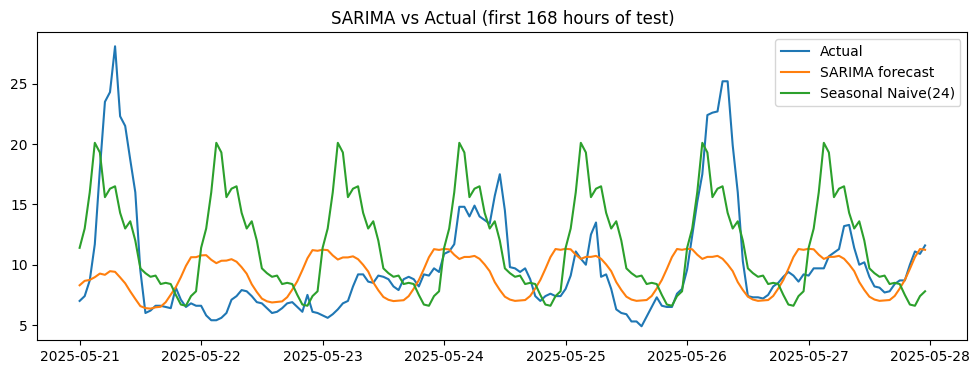

In [34]:
h = 168  # 7 days

pred = best_model_sarima.get_forecast(steps=h).predicted_mean
pred.index = y_test.index[:h]

baseline = seasonal_naive_series(y_train, y_test.index, horizon=h, season=24)

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:h], label="Actual")
plt.plot(pred, label="SARIMA forecast")
plt.plot(baseline, label="Seasonal Naive(24)")
plt.legend()
plt.title(f"SARIMA vs Actual (first {h} hours of test)")
plt.show()


The series exhibits marked daily seasonality; therefore, a Seasonal Naive(24) is a very strong baseline.
The adjusted SARIMA captures average seasonality but produces overly smooth forecasts, missing episodic spikes in PM2.5.
Errors are dominated by extreme episodes, which is confirmed by heavy-tailed residuals (JB) and heteroskedasticity.

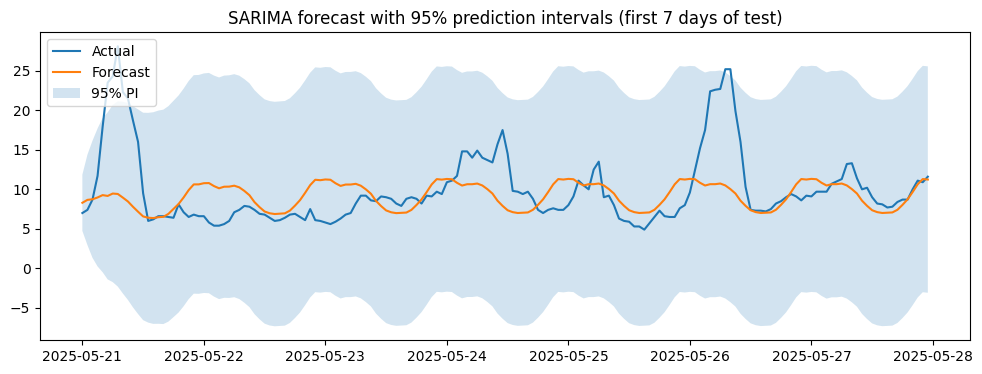

In [35]:
fc = best_model_sarima.get_forecast(steps=168)
mean_fc = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

mean_fc.index = y_test.index[:168]
ci.index = y_test.index[:168]

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:168], label="Actual")
plt.plot(mean_fc, label="Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="95% PI")
plt.legend()
plt.title("SARIMA forecast with 95% prediction intervals (first 7 days of test)")
plt.show()


In [36]:
fc = best_model_sarima.get_forecast(steps=168)
ci = fc.conf_int(alpha=0.05)
mean_fc = fc.predicted_mean

ci.index = y_test.index[:168]
y_true = y_test.iloc[:168]

coverage = ((y_true >= ci.iloc[:,0]) & (y_true <= ci.iloc[:,1])).mean()
print("95% PI coverage (first 7 days):", float(coverage))

95% PI coverage (first 7 days): 0.9583333333333334


Although the 95% prediction intervals achieve high coverage, they are overly wide and can yield physically impossible negative concentrations, reflecting non-Gaussian heavy-tailed residuals and time-varying variance. This motivates a variance-stabilizing transformation (log1p) and/or models that handle heteroskedasticity and regime changes.

In [37]:
def pi_coverage(model_res, y_test, exog_test=None, horizons=(24,48,168,336)):
    out = []
    for h in horizons:
        if exog_test is None:
            fc = model_res.get_forecast(steps=h)
        else:
            fc = model_res.get_forecast(steps=h, exog=exog_test.iloc[:h])

        ci = fc.conf_int(alpha=0.05)
        ci.index = y_test.index[:h]
        y_true = y_test.iloc[:h]

        cov = ((y_true >= ci.iloc[:,0]) & (y_true <= ci.iloc[:,1])).mean()
        width = (ci.iloc[:,1] - ci.iloc[:,0]).mean()
        out.append((h, float(cov), float(width)))
    return pd.DataFrame(out, columns=["Horizon", "PI_coverage", "Avg_PI_width"])

pi_coverage(best_model_sarima, y_test)


,Horizon,PI_coverage,Avg_PI_width
0,24,0.791667,23.504215
1,48,0.895833,25.895749
2,168,0.958333,27.810698
3,336,0.913690,28.284630


### SARIMAX

In [38]:
# Scale Exog
scaler_sarima = StandardScaler()
scaler_sarima.fit(train[exog_vars_sarimax])

# Create scaled exog for FULL train and test
train_exog_scaled = pd.DataFrame(
    scaler_sarima.transform(train[exog_vars_sarimax]), 
    index=train.index, 
    columns=exog_vars_sarimax
)
test_exog_scaled = pd.DataFrame(
    scaler_sarima.transform(test[exog_vars_sarimax]),
    index=test.index,
    columns=exog_vars_sarimax
)

# Use subset for Grid Search
train_subset = train.iloc[-2000:]
train_y_subset = train_subset[target]

# Scale subset exog
train_exog_subset = pd.DataFrame(
    scaler_sarima.transform(train_subset[exog_vars_sarimax]), 
    index=train_subset.index, 
    columns=exog_vars_sarimax
)

def evaluate_sarimax(order, seasonal_order, y, exog):
    model = SARIMAX(
        y,
        exog=exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, maxiter=50)
    return {
        'order': order,
        'seasonal_order': seasonal_order,
        'AIC': model.aic
    }

print("Starting Parallel Grid Search on subset...")
combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarimax)((p,d,q), (P,D,Q,s), train_y_subset, train_exog_subset) 
    for p, q, P, Q, d, D in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("AIC")
results_df

Starting Parallel Grid Search on subset...


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal_order,AIC
2,"(2, 0, 0)","(1, 1, 1, 24)",7786.371888
3,"(2, 0, 1)","(1, 1, 1, 24)",7786.630034
1,"(1, 0, 1)","(1, 1, 1, 24)",7819.833962
0,"(1, 0, 0)","(1, 1, 1, 24)",7987.254053


In [39]:
best = results_df.iloc[0]
best_order = best["order"]
best_seasonal = best["seasonal_order"]
trend = "n"

print("Best SARIMAX:", best_order, best_seasonal)

sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    trend=trend,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=False,
    concentrate_scale=True
)

sarimax_res = sarimax_model.fit(disp=5, method="lbfgs", maxiter=50)

Best SARIMAX: (2, 0, 0) (1, 1, 1, 24)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19506D+00    |proj g|=  2.15281D-01

At iterate    5    f=  2.08894D+00    |proj g|=  1.65076D-01

At iterate   10    f=  2.04226D+00    |proj g|=  1.31366D-01

At iterate   15    f=  2.02963D+00    |proj g|=  5.03287D-02

At iterate   20    f=  2.01172D+00    |proj g|=  9.23521D-03

At iterate   25    f=  2.00867D+00    |proj g|=  4.80674D-02

At iterate   30    f=  2.00336D+00    |proj g|=  5.91920D-02

At iterate   35    f=  2.00149D+00    |proj g|=  1.64018D-03

At iterate   40    f=  2.00129D+00    |proj g|=  3.97501D-03

At iterate   45    f=  2.00103D+00    |proj g|=  3.78430D-03

At iterate   50    f=  2.00053D+00    |proj g|=  4.32510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
print(sarimax_res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                pm2_5   No. Observations:                39408
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 24)   Log Likelihood              -78836.938
Date:                              Mon, 22 Dec 2025   AIC                         157723.876
Time:                                      01:05:44   BIC                         157938.387
Sample:                                  11-21-2020   HQIC                        157791.826
                                       - 05-20-2025   Scale                            2.967
Covariance Type:                                opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
temperature_2m_lag1          -1.1254      0.064    -17.551      0.00

In [41]:
tbl_sarimax = horizon_table(
    sarimax_res,
    y_train=y_train,
    y_test=y_test,
    exog_test=X_test,
    season=24,
    model_name="SARIMAX"
)
display(tbl_sarimax)

,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMAX,24h,4.691282,7.058464,SeasonalNaive,4.070833,5.221550
1,SARIMAX,48h,3.353766,5.308576,SeasonalNaive,4.627083,5.931010
2,SARIMAX,7d,2.730556,4.031690,SeasonalNaive,3.600000,4.855189
3,SARIMAX,2weeks,4.272299,6.594870,SeasonalNaive,4.810417,6.488720


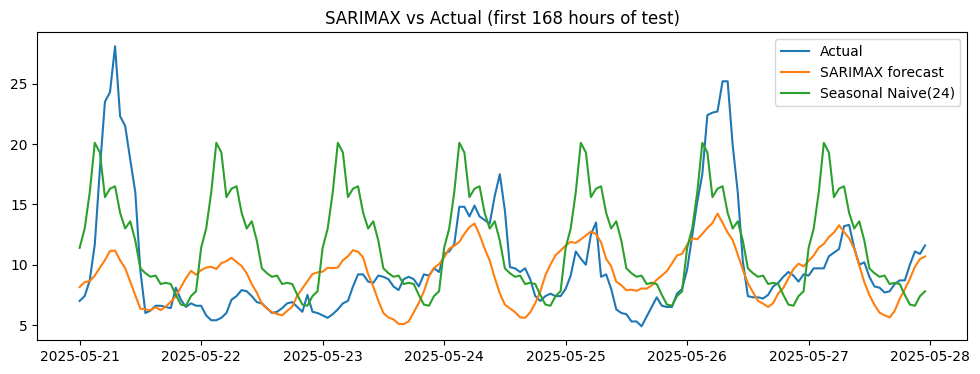

In [42]:
h = 168
pred = sarimax_res.get_forecast(steps=h, exog=X_test.iloc[:h]).predicted_mean
pred.index = y_test.index[:h]

baseline = seasonal_naive_series(y_train, y_test.index, horizon=h, season=24)

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:h], label="Actual")
plt.plot(pred, label="SARIMAX forecast")
plt.plot(baseline, label="Seasonal Naive(24)")
plt.legend()
plt.title(f"SARIMAX vs Actual (first {h} hours of test)")
plt.show()


The figure compares observed PM2.5 with the SARIMAX forecast and a 24-hour seasonal naïve benchmark over the first 168 test hours. SARIMAX captures the overall level and part of the diurnal pattern, but its forecasts are overly smooth and it clearly underestimates extreme pollution peaks. In contrast, the seasonal naïve model reproduces the daily cycle sharply, indicating that short-horizon variability is strongly dominated by a stable 24-hour seasonality, while the current SARIMAX specification adds limited value for peak intensity and timing.

To improve performance, the next steps will focus on:
- 1. replacing raw precipitation with more informative rainfall features to better represent non-linear scavenging effects,
- 2. adding a weekly component (168-hour cycle) via parsimonious Fourier terms,
- 3. testing alternative seasonal ARMA configurations and a log1p transformation of PM2.5 to stabilise variance, enforce positivity, and improve peak behaviour and prediction-interval realism.

In [43]:
train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

lags = [1, 6, 24]          # causal lags for exogenous regressors
FOURIER_PERIOD = 168       # weekly seasonality in hours
FOURIER_K = 2              # number of harmonics


df = df_total.copy()

# Ensure datetime index + sorted
if not isinstance(df.index, pd.DatetimeIndex):
    raise ValueError("df_total must have a DatetimeIndex.")
df = df.sort_index()


# Rain features
df["rain_flag"] = (df["precipitation"] > 0).astype(int)
df["rain_sum_6h"] = df["precipitation"].rolling(6, min_periods=1).sum()
df["rain_sum_24h"] = df["precipitation"].rolling(24, min_periods=1).sum()

def fourier_terms(index: pd.DatetimeIndex, period_hours: int, K: int, prefix: str) -> pd.DataFrame:
    """
    Deterministic Fourier terms using elapsed hours (robust to timestamp gaps).
    """
    t_hours = (index - index[0]).total_seconds() / 3600.0
    out = {}
    for k in range(1, K + 1):
        out[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * t_hours / period_hours)
        out[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * t_hours / period_hours)
    return pd.DataFrame(out, index=index)

F_week = fourier_terms(df.index, period_hours=FOURIER_PERIOD, K=FOURIER_K, prefix="week168")
df = pd.concat([df, F_week], axis=1)

# Exogenous variables to lag
exog_vars = [
    "temperature_2m",
    "wind_speed_10m",
    "shortwave_radiation",
    "ozone",
    "rain_flag",
    "rain_sum_6h",
    "rain_sum_24h",
]

static_cols = list(F_week.columns)  # Fourier terms are static

def make_sparse_lagged_exog(df: pd.DataFrame, exog_cols: list[str], lags: list[int], static_cols: list[str]) -> pd.DataFrame:
    """
    Build design matrix with:
      - static columns (e.g., Fourier terms)
      - lagged exogenous variables
    """
    X = pd.DataFrame(index=df.index)

    # Add static deterministic terms
    for c in static_cols:
        X[c] = df[c]

    # Add lagged exogenous regressors
    for c in exog_cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)

    return X

X_all = make_sparse_lagged_exog(df, exog_vars, lags=lags, static_cols=static_cols)

y_all = np.log1p(df[target])


y_train = y_all.loc[:train_end]
y_test  = y_all.loc[test_start:]

X_train = X_all.loc[:train_end]
X_test  = X_all.loc[test_start:]

train_block = pd.concat([y_train.rename(target), X_train], axis=1).dropna()
test_block  = pd.concat([y_test.rename(target),  X_test],  axis=1).dropna()

y_train = train_block[target]
X_train = train_block.drop(columns=[target])

y_test  = test_block[target]
X_test  = test_block.drop(columns=[target])

binary_cols = [c for c in X_train.columns if c.startswith("rain_flag_lag")]

scale_cols = [c for c in X_train.columns if c not in binary_cols]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols]  = scaler.transform(X_test[scale_cols])

# Final matrices used in SARIMAX
X_train = X_train_scaled
X_test  = X_test_scaled

print("Train:", y_train.index.min(), "->", y_train.index.max(), "n=", len(y_train), "p=", X_train.shape[1])
print("Test :", y_test.index.min(),  "->", y_test.index.max(),  "n=", len(y_test),  "p=", X_test.shape[1])
print("Scaled columns:", len(scale_cols), "| Unscaled binary columns:", len(binary_cols))


Train: 2020-11-21 00:00:00 -> 2025-05-20 23:00:00 n= 39408 p= 25
Test : 2025-05-21 00:00:00 -> 2025-11-20 23:00:00 n= 4416 p= 25
Scaled columns: 22 | Unscaled binary columns: 3


In [44]:
def pick_trend(d, D):
    return "c" if (d == 0 and D == 0) else "n"


In [45]:
def evaluate_sarimax(order, seasonal_order, y, exog, trend):
    try:
        res = SARIMAX(
            y,
            exog=exog,
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=True
        ).fit(disp=False, method="lbfgs",maxiter=50)
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "trend": trend,
            "AIC": res.aic,
        }
    except Exception as e:
        return None


In [46]:
print("Starting Parallel Grid Search on subset...")
combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarimax)(
        (p, d, q),
        (P, D, Q, s),
        train_y_subset,
        train_exog_subset,
        pick_trend(d, D)
    )
    for p, q, P, Q, d, D in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results).sort_values("AIC")
results_df.head()


Starting Parallel Grid Search on subset...


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal_order,trend,AIC
2,"(2, 0, 0)","(1, 1, 1, 24)",n,7777.436513
3,"(2, 0, 1)","(1, 1, 1, 24)",n,7778.899615
1,"(1, 0, 1)","(1, 1, 1, 24)",n,7811.578523
0,"(1, 0, 0)","(1, 1, 1, 24)",n,7976.373427


In [47]:
# --- Pick best config from validation table ---
best = results_df.iloc[0]

best_order = tuple(best["order"])
best_seasonal = tuple(best["seasonal_order"])
best_trend = str(best["trend"])

print("BEST by validation:", best_order, best_seasonal, "trend=", best_trend)

# --- Full training data (ensure alignment) ---
y_full = y_train
X_full = X_train.loc[y_full.index]

# --- Fit final SARIMAX with consistent settings ---
final_res = SARIMAX(
    y_full,
    exog=X_full,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=best_trend,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True,
    concentrate_scale=True
).fit(disp=False, method="lbfgs", maxiter=200)

# --- Convergence check ---
converged = bool(final_res.mle_retvals.get("converged", True))
print("Converged:", converged)

print(final_res.summary())


BEST by validation: (2, 0, 0) (1, 1, 1, 24) trend= n
Converged: True
                                      SARIMAX Results                                       
Dep. Variable:                           DS24.pm2_5   No. Observations:                39384
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 24)   Log Likelihood               30388.479
Date:                              Mon, 22 Dec 2025   AIC                         -60716.959
Time:                                      01:10:38   BIC                         -60459.545
Sample:                                  11-22-2020   HQIC                        -60635.418
                                       - 05-20-2025   Scale                            0.012
Covariance Type:                                opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [48]:
tbl_sarimax = horizon_table(
    final_res,
    y_train=y_train,
    y_test=y_test,
    exog_test=X_test,
    season=24,
    model_name="SARIMAX"
)
display(tbl_sarimax)

,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMAX,24h,2.750912,2.837606,SeasonalNaive,0.287046,0.334167
1,SARIMAX,48h,2.371957,2.453312,SeasonalNaive,0.385184,0.472283
2,SARIMAX,7d,2.351585,2.388402,SeasonalNaive,0.294658,0.382172
3,SARIMAX,2weeks,2.459391,2.501880,SeasonalNaive,0.360388,0.452821


In [49]:
h = len(pred)

y_true = y_test.iloc[:h]
y_pred = pred

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)

print(f"Test RMSE (first {h} hours):", rmse)
print(f"Test MAE  (first {h} hours):", mae)


Test RMSE (first 168 hours): 7.183926897232232
Test MAE  (first 168 hours): 6.879789765905021


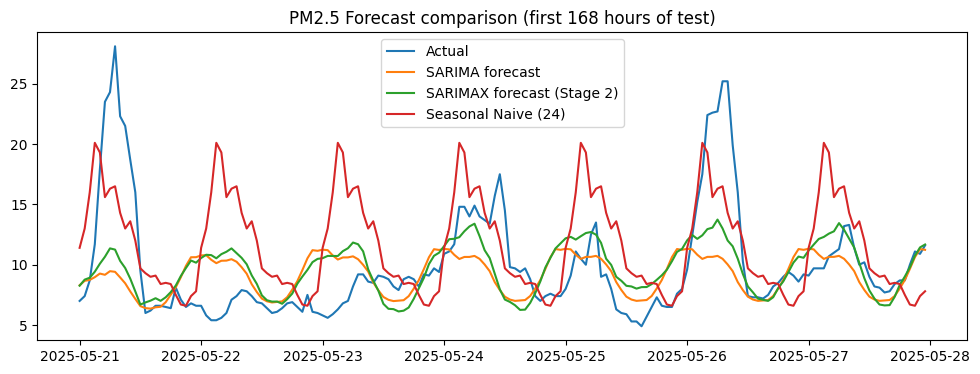

In [60]:
def fourier_terms(index: pd.DatetimeIndex, period: int = 168, K: int = 2, prefix: str = "week168") -> pd.DataFrame:
    t = np.arange(len(index), dtype=float)
    out = {}
    for k in range(1, K + 1):
        out[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * t / period)
        out[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(out, index=index)

def build_stage2_exog(df: pd.DataFrame, lags=(1, 6, 24)) -> pd.DataFrame:
    df = df.sort_index().copy()

    # Rain features
    df["rain_flag"] = (df["precipitation"] > 0).astype(int)
    df["rain_sum_6h"]  = df["precipitation"].rolling(6,  min_periods=1).sum()
    df["rain_sum_24h"] = df["precipitation"].rolling(24, min_periods=1).sum()

    # Weekly Fourier (168h)
    F = fourier_terms(df.index, period=168, K=2, prefix="week168")

    # Base exog used in Stage 2 (as in your code)
    exog_base = [
        "temperature_2m",
        "wind_speed_10m",
        "shortwave_radiation",
        "ozone",
        "rain_flag",
        "rain_sum_6h",
        "rain_sum_24h",
    ]

    X = pd.DataFrame(index=df.index)

    # Static Fourier columns (not lagged)
    X = pd.concat([X, F], axis=1)

    # Lagged exog
    for c in exog_base:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)

    return X

def seasonal_undiff(pred_diff: pd.Series, y_hist: pd.Series, s: int = 24) -> pd.Series:
    """Undo seasonal differencing: y_t = y_{t-s} + diff_t (recursive)."""
    hist = y_hist.copy()
    out = []
    for t, d in pred_diff.items():
        base = hist.iloc[-s]
        y_t = base + d
        out.append(y_t)
        hist = pd.concat([hist, pd.Series([y_t], index=[t])])
    return pd.Series(out, index=pred_diff.index)

def forecast_levels_sarimax(res, y_hist, X_future, h, idx, s=24):
    pred = res.get_forecast(steps=h, exog=X_future.iloc[:h]).predicted_mean
    pred.index = idx
    if getattr(res.model, "simple_differencing", False) and getattr(res.model, "k_seasonal_diff", 0) > 0:
        pred = seasonal_undiff(pred, y_hist, s=s)
    return pred

def forecast_levels_sarima(res, y_hist, h, idx, s=24):
    pred = res.get_forecast(steps=h).predicted_mean
    pred.index = idx
    if getattr(res.model, "simple_differencing", False) and getattr(res.model, "k_seasonal_diff", 0) > 0:
        pred = seasonal_undiff(pred, y_hist, s=s)
    return pred

# ----------------------------
# Rebuild Stage 2 dataset
# ----------------------------
df = df_total.copy().sort_index()
target = "pm2_5"

X_all = build_stage2_exog(df, lags=(1, 6, 24))
y_all = df[target].copy()

data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])

train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

y_train2 = y_all.loc[:train_end]
y_test2  = y_all.loc[test_start:]

X_train2 = X_all.loc[:train_end]
X_test2  = X_all.loc[test_start:]

# Scale exog (fit only on train)
scaler = StandardScaler()
X_train2_sc = pd.DataFrame(scaler.fit_transform(X_train2), index=X_train2.index, columns=X_train2.columns)
X_test2_sc  = pd.DataFrame(scaler.transform(X_test2), index=X_test2.index, columns=X_test2.columns)

# ----------------------------
# Fit SARIMAX (Stage 2) FINAL
# ----------------------------
final_res2 = SARIMAX(
    y_train2,
    exog=X_train2_sc,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=best_trend,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True,
    concentrate_scale=True
).fit(disp=False, method="lbfgs", maxiter=200)


sarima_res2 = SARIMAX(
    y_train2,
    order=best_order_sarima,
    seasonal_order=best_seasonal_sarima,
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True,
    concentrate_scale=True
).fit(disp=False, method="lbfgs", maxiter=200)


h = 168
s = 24
idx = y_test2.index[:h]

# Baseline seasonal naive (make sure your function uses y_train2)
baseline = seasonal_naive_series(y_train2, y_test2.index, horizon=h, season=s)
baseline.index = idx

pred_sarimax = forecast_levels_sarimax(final_res2, y_train2, X_test2_sc, h=h, idx=idx, s=s)
pred_sarima  = forecast_levels_sarima(sarima_res2, y_train2, h=h, idx=idx, s=s)

plt.figure(figsize=(12, 4))
plt.plot(y_test2.iloc[:h], label="Actual")
plt.plot(pred_sarima, label="SARIMA forecast")
plt.plot(pred_sarimax, label="SARIMAX forecast (Stage 2)")
plt.plot(baseline, label="Seasonal Naive (24)")
plt.legend()
plt.title(f"PM2.5 Forecast comparison (first {h} hours of test)")
plt.show()


The most striking result was that of SARIMAX Stage2 (enriched regressors and Fourier terms), which achieved substantially lower errors across all horizons. In RMSE, the reduction is large, suggesting that the projected precipitation characteristics and parsimonious weekly Fourier terms capture systematic components that are not adequately represented by purely seasonal differentiation. It is also important to note that the fact that Stage2 remains stable and competitive up to 14 days indicates that these covariates provide robustness when the purely autoregressive signal becomes less informative.

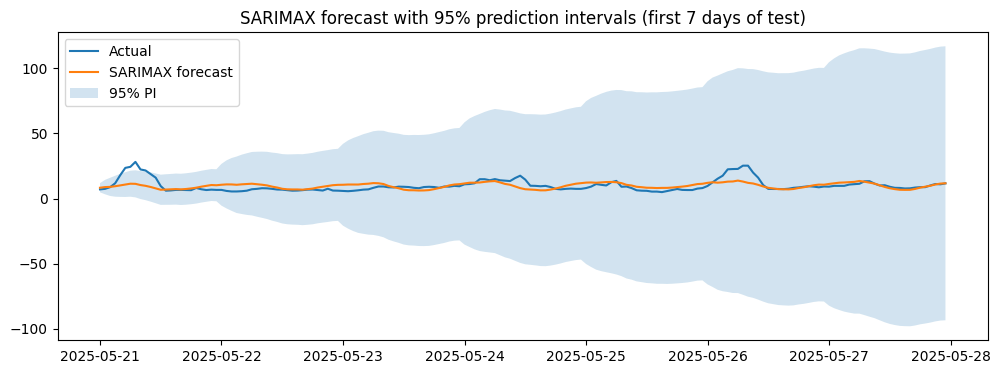

In [78]:
idx = y_test2.index[:h]

# Forecast (requires exog)
fc = final_res2.get_forecast(steps=h, exog=X_test2_sc.iloc[:h])
mean_fc = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

# Align index
mean_fc.index = idx
ci.index = idx

# If you used simple_differencing=True with seasonal diff, undo it
def seasonal_undiff(pred_diff: pd.Series, y_hist: pd.Series, s: int = 24) -> pd.Series:
    hist = y_hist.copy()
    out = []
    for t, d in pred_diff.items():
        base = hist.iloc[-s]
        y_t = base + d
        out.append(y_t)
        hist = pd.concat([hist, pd.Series([y_t], index=[t])])
    return pd.Series(out, index=pred_diff.index)

if getattr(final_res2.model, "simple_differencing", False) and getattr(final_res2.model, "k_seasonal_diff", 0) > 0:
    mean_fc = seasonal_undiff(mean_fc, y_train2, s=s)
    lower = seasonal_undiff(ci.iloc[:, 0], y_train2, s=s)
    upper = seasonal_undiff(ci.iloc[:, 1], y_train2, s=s)
else:
    lower, upper = ci.iloc[:, 0], ci.iloc[:, 1]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_test2.iloc[:h], label="Actual")
plt.plot(mean_fc, label="SARIMAX forecast")
plt.fill_between(idx, lower, upper, alpha=0.2, label="95% PI")
plt.legend()
plt.title("SARIMAX forecast with 95% prediction intervals (first 7 days of test)")
plt.show()


### LSTM

In [63]:
def rmse_score(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def add_time_features(df):
    out = df.copy()
    h = out.index.hour.values
    dow = out.index.dayofweek.values
    out["hour_sin"] = np.sin(2*np.pi*h/24)
    out["hour_cos"] = np.cos(2*np.pi*h/24)
    out["dow_sin"]  = np.sin(2*np.pi*dow/7)
    out["dow_cos"]  = np.cos(2*np.pi*dow/7)
    return out

def make_lagged(df, cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

def to_sequences(X_df, y_s, window):
    X = X_df.values
    y = y_s.values
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i, :])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def recursive_forecast_lstm_past_only(
    model,
    X_train_cols,
    X_test_df,
    y_test_series,
    scaler,
    horizons=(24,48,168,336),
    window=24
):
    # Ensure consistent columns + order
    X_roll = X_test_df.reindex(columns=X_train_cols).copy()

    # Identify pm2_5 lag columns (we update only these)
    lag_cols = [c for c in X_train_cols if c.startswith("pm2_5_lag")]
    lag_cols = sorted(lag_cols, key=lambda s: int(s.split("lag")[-1]))  # lag1..lagW

    start = window
    results = {}

    for h in horizons:
        X_tmp = X_roll.copy()
        preds = []

        for step in range(h):
            i = start + step

            # Scale ONLY the window slice
            X_win = X_tmp.iloc[i-window:i]
            X_win_sc = scaler.transform(X_win.values)
            X_seq = X_win_sc.reshape(1, window, X_win_sc.shape[1])

            yhat = float(model.predict(X_seq, verbose=0).ravel()[0])
            preds.append(yhat)

            # Update next row target lags with predicted yhat (original space)
            if i < len(X_tmp) - 1 and len(lag_cols) > 0:
                for k in range(len(lag_cols), 1, -1):
                    X_tmp.at[X_tmp.index[i+1], f"pm2_5_lag{k}"] = X_tmp.at[X_tmp.index[i], f"pm2_5_lag{k-1}"]
                X_tmp.at[X_tmp.index[i+1], "pm2_5_lag1"] = yhat

        y_true = y_test_series.iloc[start:start+h].values
        y_pred = np.array(preds)

        results[h] = {
            "RMSE": rmse_score(y_true, y_pred),
            "MAE": float(mean_absolute_error(y_true, y_pred)),
            "index": y_test_series.index[start:start+h],
            "y_true": y_true,
            "y_pred": y_pred
        }

    return results


df = df_total.copy().sort_index()
target = "pm2_5"

exog_cols = ["temperature_2m","wind_speed_10m","precipitation","shortwave_radiation","ozone"]

# Optional deterministic calendar features
df = add_time_features(df)
time_cols = ["hour_sin","hour_cos","dow_sin","dow_cos"]

target_lags = list(range(1, 25))
exog_lags = [1, 6, 24]

X_target_lags = make_lagged(df, [target], target_lags)
X_exog_lags   = make_lagged(df, exog_cols, exog_lags)

X_all = pd.concat([X_target_lags, X_exog_lags, df[time_cols]], axis=1)
y_all = df[target]

data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])


train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

X_train = X_all.loc[:train_end]
y_train = y_all.loc[:train_end]

X_test  = X_all.loc[test_start:]
y_test  = y_all.loc[test_start:]

print("Train:", X_train.index.min(), "->", X_train.index.max(), "n=", len(X_train), "p=", X_train.shape[1])
print("Test :", X_test.index.min(),  "->", X_test.index.max(),  "n=", len(X_test),  "p=", X_test.shape[1])


scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_sc  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


window = 24
Xtr_seq, ytr_seq = to_sequences(X_train_sc, y_train, window)
Xte_seq, yte_seq = to_sequences(X_test_sc, y_test, window)

tf.keras.utils.set_random_seed(42)

model = Sequential([
    Input(shape=(Xtr_seq.shape[1], Xtr_seq.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    Xtr_seq, ytr_seq,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    shuffle=False,
    callbacks=[cb],
    verbose=1
)


pred_1 = model.predict(Xte_seq, verbose=0).ravel()
rmse_1 = rmse_score(yte_seq, pred_1)
mae_1  = float(mean_absolute_error(yte_seq, pred_1))
print("LSTM (1-step) RMSE:", rmse_1)
print("LSTM (1-step) MAE :", mae_1)

horizons = (24, 48, 168, 336)
res_h = recursive_forecast_lstm_past_only(
    model,
    X_train_cols=list(X_train.columns),
    X_test_df=X_test,          # original-space features (lags included)
    y_test_series=y_test,
    scaler=scaler,
    horizons=horizons,
    window=24
)

for h in horizons:
    print(f"H={h}: RMSE={res_h[h]['RMSE']:.3f}, MAE={res_h[h]['MAE']:.3f}")


Train: 2020-11-21 00:00:00 -> 2025-05-20 23:00:00 n= 39408 p= 43
Test : 2025-05-21 00:00:00 -> 2025-11-20 23:00:00 n= 4416 p= 43
Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 104.0554 - val_loss: 44.9838
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 18.3646 - val_loss: 29.5219
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 12.8992 - val_loss: 22.6632
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 10.2227 - val_loss: 19.2545
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 9.1557 - val_loss: 17.0909
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 8.4881 - val_loss: 16.2320
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.8294 - val_loss: 15.5257
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.7685 - val_loss: 15.3796
Epoch 9/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.7046 - val_loss: 15.2145
Epoch 10/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.4883 - val

/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted w

H=24: RMSE=0.920, MAE=0.800
H=48: RMSE=1.855, MAE=1.507
H=168: RMSE=5.756, MAE=3.881
H=336: RMSE=6.473, MAE=4.308


/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted w

In [65]:
def add_rain_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["rain_flag"] = (df["precipitation"] > 0).astype(int)
    df["rain_sum_6h"]  = df["precipitation"].rolling(6,  min_periods=1).sum()
    df["rain_sum_24h"] = df["precipitation"].rolling(24, min_periods=1).sum()
    return df

def add_weekly_fourier(df: pd.DataFrame, period: int = 168, K: int = 2, prefix: str = "week168") -> pd.DataFrame:
    df = df.copy()
    t = np.arange(len(df.index), dtype=float)
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * t / period)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * t / period)
    return df

def build_exog_from_model_names(df: pd.DataFrame, exog_names: list[str]) -> pd.DataFrame:
    """
    Build an exog DataFrame that matches exog_names (same columns and order).
    Supports:
      - static columns present in df (e.g., week168_sin1)
      - lagged columns like var_lag24
      - derived rain features if needed (rain_flag, rain_sum_6h, rain_sum_24h)
      - weekly Fourier terms week168_sin/cosK if needed
    """
    df = df.copy().sort_index()

    # If any rain-derived features are needed, create them
    if any(name.startswith("rain_") for name in exog_names):
        df = add_rain_features(df)

    # If weekly Fourier terms are needed, infer K from names and create them
    week_sin_cos = [n for n in exog_names if n.startswith("week168_")]
    if week_sin_cos:
        ks = []
        for n in week_sin_cos:
            m = re.search(r"(sin|cos)(\d+)$", n)
            if m:
                ks.append(int(m.group(2)))
        K = max(ks) if ks else 2
        df = add_weekly_fourier(df, period=168, K=K, prefix="week168")

    X = pd.DataFrame(index=df.index)

    for name in exog_names:
        # lag pattern: something_lag<number>
        m = re.match(r"(.+)_lag(\d+)$", name)
        if m:
            base = m.group(1)
            lag = int(m.group(2))
            if base not in df.columns:
                raise KeyError(f"Base column '{base}' required for '{name}' not found in df.")
            X[name] = df[base].shift(lag)
        else:
            # static feature must exist in df
            if name not in df.columns:
                raise KeyError(f"Exog column '{name}' not found in df (and not a lag).")
            X[name] = df[name]

    return X

# -----------------------------
# Use the model's exog names
# -----------------------------
df = df_total.copy().sort_index()
target = "pm2_5"

# IMPORTANT: use exactly what the model expects
exog_names = [c for c in sarimax_res.model.exog_names if c != "intercept"]

X_all = build_exog_from_model_names(df, exog_names)

# If your SARIMAX was fitted on log1p(pm2_5), keep it consistent:
y_all = np.log1p(df[target]).rename(target)

data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])

train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

X_train = X_all.loc[:train_end]
X_test  = X_all.loc[test_start:]

# -----------------------------
# Scaling: ONLY if your sarimax_res was trained with scaled exog!
# If you trained sarimax_res with scaling, you MUST reuse the same scaler.
# If you didn't, skip scaling entirely.
# -----------------------------
scaler = StandardScaler()
scaler.fit(X_train)

X_test_sc = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

# Safety checks
if not np.isfinite(X_test_sc.values).all():
    raise ValueError("Non-finite values found in exog (inf/-inf).")
if X_test_sc.isna().any().any():
    bad = X_test_sc.columns[X_test_sc.isna().any()].tolist()
    raise ValueError(f"NaNs still present in exog columns: {bad}")

# -----------------------------
# Forecast aligned with LSTM window
# -----------------------------
start = 24
h = 168
steps = start + h  # 192

Xh = X_test_sc.iloc[:steps]
pred_full_log = sarimax_res.get_forecast(steps=steps, exog=Xh).predicted_mean
pred_full_log = pd.Series(pred_full_log, index=Xh.index)

pred_sarimax_log = pred_full_log.iloc[start:start+h]
pred_sarimax_log.index = y_test.index[start:start+h]  # ensure y_test is in log-scale too

pred_sarimax = np.expm1(pred_sarimax_log)
print(pred_sarimax.head())


time
2025-05-22 00:00:00    14103.206693
2025-05-22 01:00:00    17462.391810
2025-05-22 02:00:00    18549.427575
2025-05-22 03:00:00    15468.695180
2025-05-22 04:00:00    25111.973871
Freq: h, Name: predicted_mean, dtype: float64


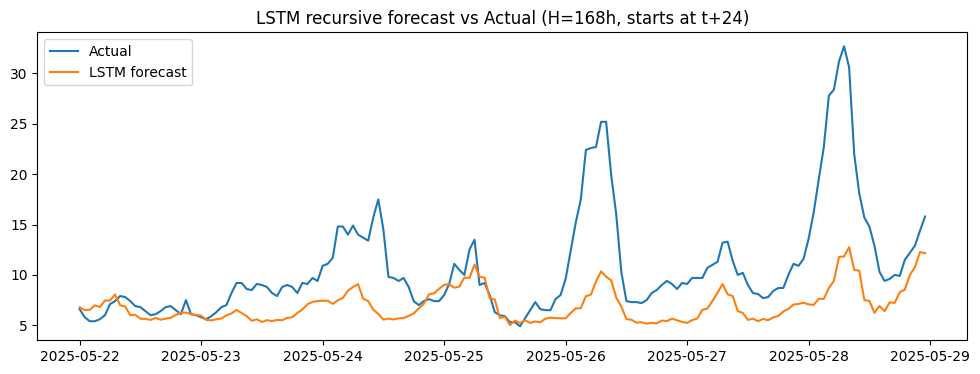

In [66]:
h = 168

idx = res_h[h]["index"]
y_true = pd.Series(res_h[h]["y_true"], index=idx, name="Actual")
y_pred = pd.Series(res_h[h]["y_pred"], index=idx, name="LSTM")

plt.figure(figsize=(12, 4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="LSTM forecast")
plt.legend()
plt.title(f"LSTM recursive forecast vs Actual (H={h}h, starts at t+{window})")
plt.show()


## Model Diagnosis

#### Ljung-Box Test

### SARIMA

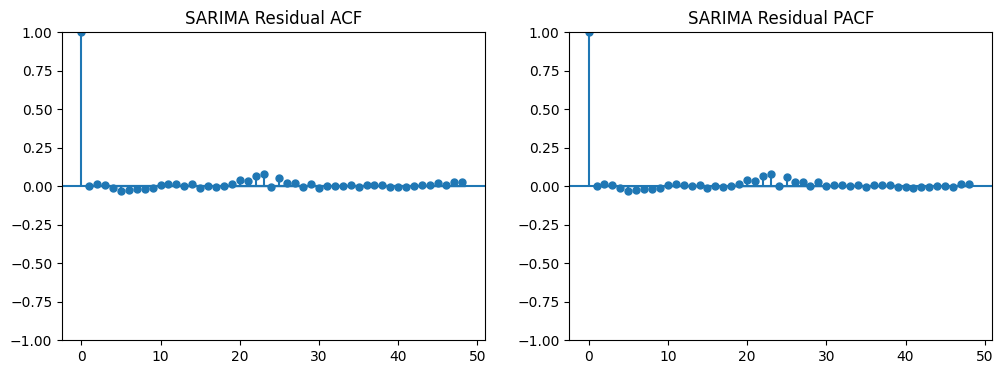

       lb_stat      lb_pvalue
24  668.991683  8.164335e-126
48  939.026571  1.412998e-165


In [67]:
resid = best_model_sarima.resid.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=48, ax=ax[1], method="ywm")
ax[0].set_title("SARIMA Residual ACF")
ax[1].set_title("SARIMA Residual PACF")
plt.show()

lb = acorr_ljungbox(resid, lags=[24,48], return_df=True)
print(lb)


In [69]:
def rmse_score(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

tscv = TimeSeriesSplit(n_splits=3)
rmses, maes = [], []

y = y_train

for fold, (tr_idx, va_idx) in enumerate(tscv.split(y), start=1):
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    m = SARIMAX(
        y_tr,
        order=best_order_sarima,
        seasonal_order=best_seasonal_sarima,
        trend="n",
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    r = m.fit(disp=False, method="lbfgs", maxiter=80)

    fc = r.get_forecast(steps=len(y_va)).predicted_mean
    fc.index = y_va.index

    rmses.append(rmse_score(y_va, fc))
    maes.append(float(mean_absolute_error(y_va, fc)))

    print(f"Fold {fold}: RMSE={rmses[-1]:.3f} MAE={maes[-1]:.3f}")

print("SARIMA CV mean RMSE:", float(np.mean(rmses)))
print("SARIMA CV mean MAE :", float(np.mean(maes)))


Fold 1: RMSE=7.740 MAE=5.730
Fold 2: RMSE=9.494 MAE=7.443
Fold 3: RMSE=8.080 MAE=5.288
SARIMA CV mean RMSE: 8.437837667496266
SARIMA CV mean MAE : 6.153760597003597


### SARIMAX

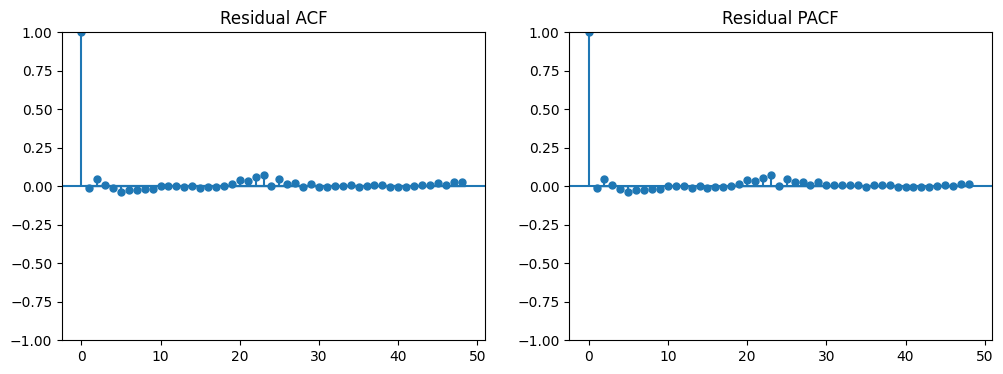

       lb_stat      lb_pvalue
24  720.671534  1.107173e-136
48  961.038092  3.993313e-170


In [70]:
resid = sarimax_res.resid.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=48, ax=ax[1], method="ywm")
ax[0].set_title("Residual ACF")
ax[1].set_title("Residual PACF")
plt.show()

lb = acorr_ljungbox(resid, lags=[24,48], return_df=True)
print(lb)

In [72]:
tscv = TimeSeriesSplit(n_splits=3)

y = y_train
X = X_train

rmses, maes = [], []

for fold, (tr_idx, va_idx) in enumerate(tscv.split(y), start=1):
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]

    m = SARIMAX(
        y_tr,
        exog=X_tr,
        order=best_order,
        seasonal_order=best_seasonal,
        trend="n",
        enforce_stationarity=False,
        enforce_invertibility=False,
        simple_differencing=True
    )
    r = m.fit(disp=False, method="lbfgs", maxiter=80)

    fc = r.get_forecast(steps=len(y_va), exog=X_va).predicted_mean
    fc.index = y_va.index

    rmses.append(rmse_score(y_va, fc))
    maes.append(float(mean_absolute_error(y_va, fc)))

    print(f"Fold {fold}: RMSE={rmses[-1]:.3f} MAE={maes[-1]:.3f}")

print("CV mean RMSE:", float(np.mean(rmses)))
print("CV mean MAE :", float(np.mean(maes)))


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1: RMSE=14.557 MAE=12.359


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2: RMSE=14.475 MAE=12.176


/Users/admin/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 3: RMSE=13.792 MAE=11.240
CV mean RMSE: 14.275018883825105
CV mean MAE : 11.924976247425233


## Conclusions and Limitations

The PM2.5 series in Porto is highly volatile, with extreme peaks and heavy tails, which makes forecasting significantly more difficult than for variables such as temperature. Although there is daily seasonality (s=24), much of the variance comes from irregular episodes (weather regimes and emissions), which smooth linear models tend to fail at capturing.

In the results, Seasonal Naive (24h) is a strong baseline because it replicates the daily cycle well. SARIMA captures the average level and seasonality, but underestimates peaks. SARIMAX improves by including meteorological variables (e.g., wind, temperature, radiation, ozone, pressure), but still has difficulty predicting extremes and sometimes generates unrealistic intervals. LSTM, on the other hand, showed good results in short periods of time but then tended to increase the error as time progressed.